# CWRU Bearing Fault Diagnosis with Spectrogram and Scalogram Inputs

This notebook implements a Convolutional Neural Network (CNN) for fault diagnosis of rolling element bearings using the Case Western Reserve University (CWRU) dataset. The methodology is based on Verstraete et al. (2017), which uses time-frequency image representations (spectrograms via STFT and scalograms via Morlet wavelet transform) as inputs to a CNN. The CNN architecture features double convolutional layers before pooling to enhance feature expressivity.


## Overview
- **Dataset**: CWRU Bearing Data (2HP load, various fault types and sizes)
- **Input**: 96x96 pixel spectrogram or scalogram images
- **Model**: CNN with three stages of double conv layers (32, 64, 128 filters), max pooling, and two dense layers
- **Training**: 5-fold stratified cross-validation with early stopping
- **Evaluation**: Accuracy, confusion matrices, and fold-wise performance plots

## Requirements
- Python libraries: tensorflow, numpy, scipy, scikit-learn, matplotlib, seaborn, pywt, skimage
- CWRU dataset files in 'CWRU_BearingData_Load_2HP' folder

Run cells sequentially to load data, preprocess, train the model, and evaluate results.

In [3]:
# Setup for Reproducibility
import tensorflow as tf
import numpy as np
import random
import os

# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Import additional libraries
import scipy.io
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from skimage.transform import resize
import pywt  # For wavelet transform

## Load CWRU Bearing Data

The `ImportData` function loads the CWRU dataset files (.mat) containing vibration signals for normal and fault conditions (inner race, ball, outer race) at various fault sizes under a 2HP load. The data is stored in a list for further processing.

In [4]:
def ImportData():
    folder_path = 'CWRU_BearingData_Load_2HP'
    file_paths = [
        os.path.join(folder_path, '99.mat'),
        os.path.join(folder_path, '111.mat'),
        os.path.join(folder_path, '124.mat'),
        os.path.join(folder_path, '137.mat'),
        os.path.join(folder_path, '176.mat'),
        os.path.join(folder_path, '191.mat'),
        os.path.join(folder_path, '203.mat'),
        os.path.join(folder_path, '215.mat'),
        os.path.join(folder_path, '228.mat'),
        os.path.join(folder_path, '240.mat')
    ]
    data_keys = [
        'X099_DE_time', 'X111_DE_time', 'X124_DE_time', 'X137_DE_time',
        'X176_DE_time', 'X191_DE_time', 'X203_DE_time', 'X215_DE_time',
        'X228_DE_time', 'X240_DE_time'
    ]
    data = [scipy.io.loadmat(fp)[key] for fp, key in zip(file_paths, data_keys)]
    return data

## Time-Frequency Image Generation

The following functions generate spectrogram and scalogram images from vibration signal segments, as per Verstraete et al. (2017):
- **Spectrogram**: Uses Short-Time Fourier Transform (STFT) with a Hann window, 256-point segments, and 128-point overlap. Images are normalized and resized to 96x96 pixels.
- **Scalogram**: Uses Continuous Wavelet Transform (CWT) with the Morlet wavelet, scales 1 to 128. Magnitude is normalized and resized to 96x96 pixels.

In [5]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape=(96, 96)):
    """
    Calculate the spectrogram of an array data_y_vector and resize it to image_shape.
    """
    fs = 48000
    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs,
        nperseg=256,
        noverlap=128,
        window='hann'
    )
    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)
    return sxx

def generate_scalogram_image(data_y_vector, image_shape=(96, 96)):
    """
    Calculate the scalogram using Morlet wavelet and resize it to image_shape.
    """
    fs = 48000
    scales = np.arange(1, 128)  # Adjust scales for Morlet wavelet
    coef, freqs = pywt.cwt(
        data_y_vector,
        scales,
        'morl',
        sampling_period=1/fs
    )
    coef = np.abs(coef)  # Use magnitude
    coef = min_max_norm(coef)
    coef = resize(coef, image_shape, mode='constant', anti_aliasing=True)
    return coef

## Data Preprocessing

The `Sampling` function segments the vibration signals into blocks, and `DataPreparation` generates spectrogram or scalogram images for each segment. Labels are created in one-hot encoded format (`Y_CNN`) for CNN training and as integers (`Y`) for stratification. The output is a 4D array of images and corresponding labels.

In [6]:
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T
    return SplitData

def DataPreparation(Data, interval_length, samples_per_block, image_type='spectrogram'):
    """
    Prepare data by generating spectrogram or scalogram images.
    """
    X = []
    LabelPositional = []
    Label = []
    for count, data in enumerate(Data):
        SplitData = Sampling(data, interval_length, samples_per_block)
        images = []
        for segment in SplitData:
            if image_type == 'spectrogram':
                img = generate_spectrogram_image(segment)
            elif image_type == 'scalogram':
                img = generate_scalogram_image(segment)
            images.append(img)
        images = np.array(images)
        y = np.zeros([len(SplitData), 10])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        X.append(images)
        LabelPositional.append(y)
        Label.append(y1)
    X = np.concatenate(X, axis=0)
    LabelPositional = np.concatenate(LabelPositional, axis=0)
    Label = np.concatenate(Label, axis=0)
    return X, LabelPositional, Label

## CNN Model Definition

The `CNN_2D` class defines the CNN architecture as per Verstraete et al. (2017):
- Three stages, each with two convolutional layers (32, 64, 128 filters, 3x3 kernels) followed by 2x2 max pooling.
- Two dense layers (100 units each) with dropout (0.5) before the second dense layer.
- Output layer with 10 units (softmax) for 10-class classification.
- Compiled with Adam optimizer and categorical crossentropy loss.

In [7]:
class CNN_2D():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 1)),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(96, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

## Main Execution

This section executes the pipeline:
- Loads and preprocesses data to generate 96x96 images (spectrogram or scalogram).
- Splits data into training (80%) and test (20%) sets with stratification.
- Performs 5-fold cross-validation with early stopping and model checkpointing.
- Saves the best model for each fold.

**Parameters**:
- `image_type`: Set to 'scalogram' or 'spectrogram' to choose input type.
- `image_shape`: 96x96 pixels for high accuracy (per Verstraete et al.).
- `kSplits`: 5 for cross-validation.
- `foldername`: Directory to save model checkpoints.

In [8]:
# Parameters
interval_length = 320
samples_per_block = 1600
image_type = 'scalogram'  # Change to 'spectrogram' to use spectrograms
image_shape = (96, 96)
kSplits = 5
foldername = "CNN2D_results/Scalogram_Spectrogram/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

# Load and prepare data
Data = ImportData()
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block, image_type=image_type)
Input_2D = X.reshape([-1, image_shape[0], image_shape[1], 1])
print(f"Shape of Input Data: {Input_2D.shape}")

# Train-test split
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(
    Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y
)

# K-fold cross-validation
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True)
accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train), 10])
y_2D_val = np.zeros([len(X_2D_train), 10])
kfold_test_len = []
fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Train the model
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):
    checkpoint_filepath = foldername + f"best_model_{k}.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    Classification_2D = CNN_2D()
    history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )
    print(f"Best model saved at: {checkpoint_filepath}")
    CNN_2D_best_model = load_model(checkpoint_filepath)
    print("Best model loaded successfully!")
    
    fl2 = fl1 + len(test)
    pred_all_val[fl1:fl2, :] = CNN_2D_best_model.predict(X_2D_train[test])
    y_2D_val[fl1:fl2, :] = y_2D_train[test]
    kfold_test_len.append(fl2 - fl1)
    fl1 = fl2

    train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train])
    accuracy_train.append(train_accuracy)
    val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test])
    accuracy_val.append(val_accuracy)
    test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test)
    accuracy_test.append(test_accuracy)
    
    k += 1

Shape of Input Data: (15169, 96, 96, 1)


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-11 11:07:24.606482: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-11 11:07:24.626218: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5915 - loss: 1.1129

2025-06-11 11:13:40.347425: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-11 11:13:40.348333: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.98929, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.5921 - loss: 1.1113 - val_accuracy: 0.9893 - val_loss: 0.0361
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9284 - loss: 0.1969
Epoch 2: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.9285 - loss: 0.1969 - val_accuracy: 0.9559 - val_loss: 0.1197
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9507 - loss: 0.1517
Epoch 3: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 772s 3s/step - accuracy: 0.9507 - loss: 0.1516 - val_accuracy: 0.9839 - val_loss: 0.0515
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9522 - loss: 0.1319
Epoch 4: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.9522 - loss: 0.1319 - val_accuracy: 0.9794 - val_loss: 0.0677
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9617 - loss: 0.1091
Epoch 5: val_accuracy did not i

304/304 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9759 - loss: 0.0680 - val_accuracy: 0.9909 - val_loss: 0.0221
Epoch 9/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9740 - loss: 0.0710
Epoch 9: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.9740 - loss: 0.0710 - val_accuracy: 0.9881 - val_loss: 0.0365
Epoch 10/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9772 - loss: 0.0666
Epoch 10: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9772 - loss: 0.0666 - val_accuracy: 0.9740 - val_loss: 0.0785
Epoch 11/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9763 - loss: 0.0664
Epoch 11: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.9763 - loss: 0.0664 - val_accuracy: 0.9909 - val_loss: 0.0284
Epoch 12/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9743 - loss: 0.0602
Epoch 12: val_accuracy imp

304/304 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.9743 - loss: 0.0602 - val_accuracy: 0.9922 - val_loss: 0.0236
Epoch 13/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9809 - loss: 0.0504
Epoch 13: val_accuracy improved from 0.99217 to 0.99629, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.9809 - loss: 0.0504 - val_accuracy: 0.9963 - val_loss: 0.0087
Epoch 14/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9851 - loss: 0.0425
Epoch 14: val_accuracy did not improve from 0.99629
304/304 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9851 - loss: 0.0425 - val_accuracy: 0.9963 - val_loss: 0.0116
Epoch 15/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9814 - loss: 0.0534
Epoch 15: val_accuracy improved from 0.99629 to 0.99670, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.9814 - loss: 0.0534 - val_accuracy: 0.9967 - val_loss: 0.0108
Epoch 16/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9842 - loss: 0.0409
Epoch 16: val_accuracy did not improve from 0.99670
304/304 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9842 - loss: 0.0409 - val_accuracy: 0.9942 - val_loss: 0.0165
Epoch 17/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9838 - loss: 0.0470
Epoch 17: val_accuracy did not improve from 0.99670
304/304 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9838 - loss: 0.0470 - val_accuracy: 0.9951 - val_loss: 0.0124
Epoch 18/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9856 - loss: 0.0422
Epoch 18: val_accuracy improved from 0.99670 to 0.99794, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.9856 - loss: 0.0422 - val_accuracy: 0.9979 - val_loss: 0.0073
Epoch 19/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9887 - loss: 0.0320
Epoch 19: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 2718s 9s/step - accuracy: 0.9887 - loss: 0.0320 - val_accuracy: 0.9975 - val_loss: 0.0083
Epoch 20/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9885 - loss: 0.0331
Epoch 20: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.9885 - loss: 0.0331 - val_accuracy: 0.9975 - val_loss: 0.0086
Epoch 21/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9888 - loss: 0.0388
Epoch 21: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.9888 - loss: 0.0388 - val_accuracy: 0.9951 - val_loss: 0.0133
Epoch 22/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9872 - loss: 0.0352
Epoch 22: val_accuracy 

304/304 ━━━━━━━━━━━━━━━━━━━━ 1024s 3s/step - accuracy: 0.9872 - loss: 0.0352 - val_accuracy: 0.9984 - val_loss: 0.0074
Epoch 23/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9847 - loss: 0.0519
Epoch 23: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.9847 - loss: 0.0518 - val_accuracy: 0.9975 - val_loss: 0.0073
Epoch 24/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9923 - loss: 0.0235
Epoch 24: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.9923 - loss: 0.0236 - val_accuracy: 0.9963 - val_loss: 0.0113
Epoch 25/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9884 - loss: 0.0304
Epoch 25: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.9884 - loss: 0.0304 - val_accuracy: 0.9967 - val_loss: 0.0116
Epoch 26/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9902 - loss: 0.0284
Epoch 26: val_accuracy 

304/304 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.9952 - loss: 0.0135 - val_accuracy: 0.9988 - val_loss: 0.0041
Epoch 48/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9972 - loss: 0.0108
Epoch 48: val_accuracy did not improve from 0.99876
304/304 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9972 - loss: 0.0108 - val_accuracy: 0.9959 - val_loss: 0.0119
Epoch 49/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9942 - loss: 0.0145
Epoch 49: val_accuracy did not improve from 0.99876
304/304 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.9942 - loss: 0.0145 - val_accuracy: 0.9984 - val_loss: 0.0051
Epoch 50/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9938 - loss: 0.0190
Epoch 50: val_accuracy did not improve from 0.99876
304/304 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.9938 - loss: 0.0191 - val_accuracy: 0.9967 - val_loss: 0.0130
Epoch 51/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9931 - loss: 0.0214
Epoch 51: val_accuracy d

Best model loaded successfully!


2025-06-12 01:01:10.325076: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 01:01:10.331120: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 29s 374ms/step


2025-06-12 01:01:43.652686: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 01:01:43.653130: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 114s 376ms/step - accuracy: 1.0000 - loss: 3.3807e-04


2025-06-12 01:03:38.781540: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 01:03:38.781807: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 371ms/step - accuracy: 0.9991 - loss: 0.0016


2025-06-12 01:04:07.849781: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 01:04:07.850070: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

95/95 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.9985 - loss: 0.0040
Epoch 1/200


2025-06-12 01:04:48.459860: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 01:04:48.460341: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6149 - loss: 1.0617

2025-06-12 01:10:55.513005: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 01:10:55.513679: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.96951, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.6154 - loss: 1.0602 - val_accuracy: 0.9695 - val_loss: 0.1031
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9240 - loss: 0.2040
Epoch 2: val_accuracy improved from 0.96951 to 0.99052, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.9241 - loss: 0.2040 - val_accuracy: 0.9905 - val_loss: 0.0348
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9486 - loss: 0.1532
Epoch 3: val_accuracy improved from 0.99052 to 0.99094, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.9486 - loss: 0.1532 - val_accuracy: 0.9909 - val_loss: 0.0328
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9565 - loss: 0.1203
Epoch 4: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.9565 - loss: 0.1203 - val_accuracy: 0.9876 - val_loss: 0.0318
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9653 - loss: 0.1052
Epoch 5: val_accuracy improved from 0.99094 to 0.99258, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.9653 - loss: 0.1052 - val_accuracy: 0.9926 - val_loss: 0.0178
Epoch 6/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9685 - loss: 0.0906
Epoch 6: val_accuracy did not improve from 0.99258
304/304 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.9685 - loss: 0.0907 - val_accuracy: 0.9856 - val_loss: 0.0389
Epoch 7/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9654 - loss: 0.0996
Epoch 7: val_accuracy did not improve from 0.99258
304/304 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.9654 - loss: 0.0996 - val_accuracy: 0.9522 - val_loss: 0.1216
Epoch 8/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9649 - loss: 0.1067
Epoch 8: val_accuracy did not improve from 0.99258
304/304 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9649 - loss: 0.1067 - val_accuracy: 0.9881 - val_loss: 0.0386
Epoch 9/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9770 - loss: 0.0722
Epoch 9: val_accuracy did not i

304/304 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.9742 - loss: 0.0752 - val_accuracy: 0.9963 - val_loss: 0.0136
Epoch 13/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9844 - loss: 0.0482
Epoch 13: val_accuracy did not improve from 0.99629
304/304 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9844 - loss: 0.0482 - val_accuracy: 0.9951 - val_loss: 0.0145
Epoch 14/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9810 - loss: 0.0562
Epoch 14: val_accuracy did not improve from 0.99629
304/304 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9810 - loss: 0.0562 - val_accuracy: 0.9839 - val_loss: 0.0484
Epoch 15/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9855 - loss: 0.0467
Epoch 15: val_accuracy did not improve from 0.99629
304/304 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.9855 - loss: 0.0467 - val_accuracy: 0.9951 - val_loss: 0.0213
Epoch 16/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9823 - loss: 0.0471
Epoch 16: val_accuracy d

304/304 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9855 - loss: 0.0466 - val_accuracy: 0.9971 - val_loss: 0.0123
Epoch 21/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9893 - loss: 0.0317
Epoch 21: val_accuracy did not improve from 0.99712
304/304 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.9893 - loss: 0.0317 - val_accuracy: 0.9831 - val_loss: 0.0597
Epoch 22/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9894 - loss: 0.0304
Epoch 22: val_accuracy did not improve from 0.99712
304/304 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9894 - loss: 0.0304 - val_accuracy: 0.9901 - val_loss: 0.0357
Epoch 23/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.9909 - loss: 0.0279 
Epoch 33: val_accuracy did not improve from 0.99712
304/304 ━━━━━━━━━━━━━━━━━━━━ 11191s 37s/step - accuracy: 0.9909 - loss: 0.0279 - val_accuracy: 0.9959 - val_loss: 0.0183
Epoch 34/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9888 - loss: 0.0331
Epoch 34: val_accur

304/304 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.9949 - loss: 0.0155 - val_accuracy: 0.9984 - val_loss: 0.0080
Epoch 38/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9957 - loss: 0.0146
Epoch 38: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.9957 - loss: 0.0146 - val_accuracy: 0.9984 - val_loss: 0.0106
Epoch 39/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9917 - loss: 0.0339
Epoch 39: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.9917 - loss: 0.0339 - val_accuracy: 0.9967 - val_loss: 0.0121
Epoch 40/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9922 - loss: 0.0242
Epoch 40: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.9922 - loss: 0.0241 - val_accuracy: 0.9967 - val_loss: 0.0133
Epoch 41/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9942 - loss: 0.0179
Epoch 41: val_accuracy d

304/304 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.9920 - loss: 0.0238 - val_accuracy: 0.9992 - val_loss: 0.0067
Epoch 60/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9946 - loss: 0.0146
Epoch 60: val_accuracy did not improve from 0.99918
304/304 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.9946 - loss: 0.0146 - val_accuracy: 0.9930 - val_loss: 0.0319
Epoch 61/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9925 - loss: 0.0198
Epoch 61: val_accuracy did not improve from 0.99918
304/304 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.9925 - loss: 0.0198 - val_accuracy: 0.9959 - val_loss: 0.0186
Epoch 62/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9958 - loss: 0.0183
Epoch 62: val_accuracy did not improve from 0.99918
304/304 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.9958 - loss: 0.0183 - val_accuracy: 0.9955 - val_loss: 0.0155
Epoch 63/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9960 - loss: 0.0121
Epoch 63: val_accuracy d

Best model loaded successfully!


2025-06-12 17:09:19.535730: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 17:09:19.537621: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 2048, but received input with shape (32, 18432)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 96, 96, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

## Model Evaluation

Evaluate the trained model by computing average accuracies across folds for training, validation, and test sets. Visualize performance with confusion matrices for train and test sets, and bar plots for fold-wise and train vs. test accuracies.

CNN 2D train accuracy = 100.0
CNN 2D validation accuracy = 99.8763918876648
CNN 2D test accuracy = 99.86816048622131


2025-06-12 19:33:40.458149: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 19:33:40.461007: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 2048, but received input with shape (32, 18432)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 96, 96, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

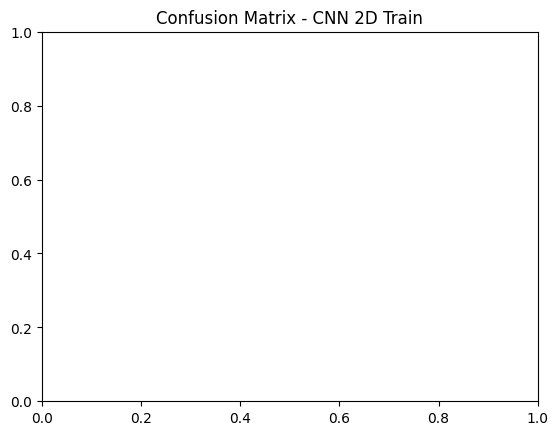

In [9]:
CNN_2D_train_accuracy = np.average(accuracy_train) * 100
print(f'CNN 2D train accuracy = {CNN_2D_train_accuracy}')
CNN_2D_val_accuracy = np.average(accuracy_val) * 100
print(f'CNN 2D validation accuracy = {CNN_2D_val_accuracy}')
CNN_2D_test_accuracy = np.average(accuracy_test) * 100
print(f'CNN 2D test accuracy = {CNN_2D_test_accuracy}')

def ConfusionMatrix(Model, X, y):
    y_pred = np.argmax(Model.predict(X), axis=1)
    ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
    return ConfusionMat

# Plot results
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70, 100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])
plt.show()

## Notes

- **Running the Notebook**: Ensure the CWRU dataset files are in the 'CWRU_BearingData_Load_2HP' folder. Install required libraries (e.g., `pip install PyWavelets` for pywt).
- **Switching Input Types**: Change `image_type` to 'spectrogram' in the main execution cell to use spectrograms instead of scalograms.
- **Performance**: Per Verstraete et al., scalograms achieve up to 99.5% accuracy on CWRU data with 96x96 images, outperforming spectrograms (99.5%) and HHT (97.6%).
- **Scalability**: 96x96 images increase computational load. For lower memory usage, set `image_shape = (32, 32)`, but expect reduced accuracy (e.g., 98.8% for scalograms).

This notebook provides an interactive environment to experiment with time-frequency-based fault diagnosis, leveraging the strengths of CNNs for automatic feature learning.